on a Darwin machine, nodename Mac.attlocal.net, release 24.5.0, version Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:26 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8112, machine arm64 
 The HOME was detected:/Users/hugopenichou
parameters:3 arguments:2
GL_MAX_EVAL_ORDER:30, mesh threads:1
 /Users/hugopenichou/.cgx opened

 reading file
 done 

 Living_hinge_1.fbd opened

 reading file
 # sys gmsh part.step -clcurv -3 -o gmsh.inp -order 2
******************************************************************************
*  read ccx input                                   4.4.2002 wi              *
*                                                                            *
*                                                                            *
* -only free-format is supported. fixed format might cause a prg-crash.      *
*                                                                            *
*                                                                            *

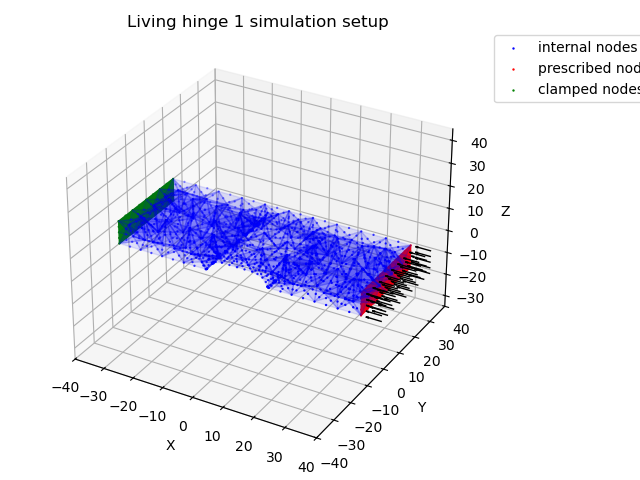

In [38]:
import os
import multiprocessing
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

part_name = "Living_hinge_1"
meshing_accuracy = 50
displacement_magnitude =  -1.000e-2

# Modify the geo file
with open("Living_hinge_1.geo", "r") as file:
    lines = file.readlines()

with open("Living_hinge_1.geo", "w") as file:
    for line in lines:
        if line.strip().startswith("Merge"):
            file.write(f'Merge "{part_name}.step";\n')
        elif line.strip().startswith("Mesh.CharacteristicLengthMax"):
            file.write(f"Mesh.CharacteristicLengthMax = {meshing_accuracy};\n")
        else:
            file.write(line) 

# Enable multithreading for ccx
os.environ['OMP_NUM_THREADS'] = str(multiprocessing.cpu_count())
snap = os.listdir(os.curdir)
os.system(f"cgx -b Living_hinge_1.fbd")

def regroup_faces_C3D10(elements, node_coords, upper_nset, lower_nset):
    upper_faces = []
    lower_faces = []
    other_faces = []

    for elem in elements:
        if len(elem) < 4:
            continue
        n1, n2, n3, n4 = elem[:4]

        try:
            face_list = [
                [n1, n2, n3],
                [n1, n2, n4],
                [n1, n3, n4],
                [n2, n3, n4]
            ]
            for face in face_list:
                nodes_in_face = [node_coords[n] for n in face]
                if all(n in upper_nset for n in face):
                    upper_faces.append(nodes_in_face)
                elif all(n in lower_nset for n in face):
                    lower_faces.append(nodes_in_face)
                else:
                    other_faces.append(nodes_in_face)
        except KeyError as e:
            print(f"Warning: Node ID {e} not found. Skipping element.")
    return upper_faces, lower_faces, other_faces

def group_faces(node_coords):
    x = [coord[0] for coord in node_coords.values()]
    y = [coord[1] for coord in node_coords.values()]
    z = [coord[2] for coord in node_coords.values()]

    group1 = {}  # fixed typo
    group2 = {}


    group1_threshold = 40
    group2_threshold = -40
    tolerance = 0.00005

    for key , values in node_coords.items():
        if np.abs( values[0] - group1_threshold ) < tolerance:
            group1[key] = values 
        elif np.abs( values[0] - group2_threshold ) < tolerance: 
            group2[key] = values 

    groups = {}
    groups["group1"] = group1
    groups["group2"] = group2

    return groups 


node_coords = {}
elements = []
plot_faces = True
isGroup_face = True
plot_nodes = True
displacement_magnitude = 5.0  # or whatever value you want
displacement_vector = True

with open("all.msh", "r") as file:
    in_node_section = False
    in_element_section = False 
    for line in file:
        if line.startswith("*NODE"):
            in_node_section = True
            in_element_section = False 
            continue
        if line.startswith("*ELEMENT"):
            in_node_section = False 
            in_element_section = True
            continue
        if in_node_section:
            parts = line.strip().split(",")
            if len(parts) >= 4:
                node_id = int(parts[0])
                x, y, z = map(float, parts[1:4])
                node_coords[node_id] = (x, y, z)
        if in_element_section and not line.startswith("*"):
            parts = [int(p) for p in line.split(",")]
            element_id = parts[0]
            node_ids = parts[1:]
            if len(node_ids) == 10:
                elements.append(node_ids)


# Separate coordinates by label sets
if isGroup_face:
    grouped_faces = group_faces(node_coords)
    upper_nset = list(grouped_faces["group1"].keys())
    lower_nset = list(grouped_faces["group2"].keys())
    basic_coords = [ node_coords[k] for k in node_coords if k not in lower_nset and k not in upper_nset ]
    upper_coords = [ node_coords[k] for k in node_coords if k in upper_nset ]
    lower_coords = [ node_coords[k] for k in node_coords if k in lower_nset ]
    upper_coords = np.array(upper_coords)
    lower_coords = np.array(lower_coords)
else:
    basic_coords = [node_coords[k] for k in node_coords ]

# Convert to numpy arrays
basic_coords = np.array(basic_coords)

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if plot_nodes:
    if len(basic_coords) > 0:
        ax.scatter(basic_coords[:, 0], basic_coords[:, 1], basic_coords[:, 2], c='blue', s = 0.5 , label='internal nodes')
    if isGroup_face:
        if len(upper_coords) > 0:
            ax.scatter(upper_coords[:, 0], upper_coords[:, 1], upper_coords[:,2], c='red', s=0.5, label='prescribed nodes')
        if len(lower_coords) > 0:
            ax.scatter( lower_coords[:,0], lower_coords[:,1], lower_coords[:,2], c='green', s=0.5 , label='clamped nodes')

# if plot_faces:
#     faces = regroup_faces_C3D10(elements, node_coords)
#     poly = Poly3DCollection(faces, alpha=0.3, edgecolor='k')
#     ax.add_collection3d(poly)

if plot_faces:
    upper_faces, lower_faces, other_faces = regroup_faces_C3D10(elements, node_coords, upper_nset, lower_nset)
    
    if upper_faces:
        poly_upper = Poly3DCollection(upper_faces, alpha=1, edgecolor='red', facecolor='red')
        ax.add_collection3d(poly_upper)
    if lower_faces:
        poly_lower = Poly3DCollection(lower_faces, alpha=1, edgecolor='green', facecolor='green')
        ax.add_collection3d(poly_lower)
    if other_faces:
        poly_other = Poly3DCollection(other_faces, alpha=0.05, edgecolor='blue', facecolor='blue')
        ax.add_collection3d(poly_other)

# Plot displacement vectors on upper nodes
x = 30 
if displacement_vector:
    if isGroup_face and len(upper_coords) > 0:
        # Define vectors
        U = np.full(len(upper_coords), -displacement_magnitude)
        V = np.zeros(len(upper_coords))
        W = np.zeros(len(upper_coords))

        ax.quiver(
            upper_coords[:, 0]+displacement_magnitude+( displacement_magnitude* x/100), upper_coords[:, 1], upper_coords[:, 2],  # starting points
            U, V, W,  # vector components
            length=1.0, normalize=False, color='black', linewidth=1, arrow_length_ratio=0.2
        )

ax.set_title(f"{part_name.split('_')[0]} {part_name.split('_')[1]} {part_name.split('_')[2]} simulation setup")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), borderaxespad=0.)

# Set equal aspect ratio
all_coords = np.concatenate([basic_coords] + ([upper_coords] if isGroup_face else []) + ([lower_coords] if isGroup_face else []))
x_limits = [np.min(all_coords[:, 0]), np.max(all_coords[:, 0])]
y_limits = [np.min(all_coords[:, 1]), np.max(all_coords[:, 1])]
z_limits = [np.min(all_coords[:, 2]), np.max(all_coords[:, 2])]

x_center = np.mean(x_limits)
y_center = np.mean(y_limits)
z_center = np.mean(z_limits)
max_range = max(np.ptp(x_limits), np.ptp(y_limits), np.ptp(z_limits)) / 2

ax.set_xlim(x_center - max_range, x_center + max_range)
ax.set_ylim(y_center - max_range, y_center + max_range)
ax.set_zlim(z_center - max_range, z_center + max_range)

plt.tight_layout()
plt.savefig(f"{part_name.split('_')[0]} {part_name.split('_')[1]} {part_name.split('_')[2]}.png", dpi=300, bbox_inches='tight')
plt.show()

We are analysing the effect of displacement on the face of the object. Therfore we take all the previous nodes associater with labeled faces and we relabeled them as a support set and a displacment set. 

In [2]:
with open("upper.nam", "w") as file:
    file.write('**Nodes corresponding to the top surface\n')
    file.write('*NSET, NSET=Nupper\n')
    for node in upper_nset:
        file.write(f'    {node}\n')

with open("lower.nam", "w") as file:
    file.write('**Node corresponding to the bottom surface\n')
    file.write('*NSET, NSET=Nlower\n')
    for node in lower_nset:
        file.write(f'    {node}\n')